In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
from IPython.display import display, HTML
# chemin en modifer
chemin = "/Users/thomassinapi/Desktop/M1 Data Science/TER/dataprojectstage_masterUPS.xlsx"

df = pd.read_excel(chemin)

In [15]:
# transforme les variables ages en catégories (18-23, 24-30, 31-40, 41-50, 51-60, 61-70, 71-90)
df['Age'] = pd.cut(df['Age'], bins=[0, 23, 30, 40, 50, 60, 70, 100], labels=['0-23', '24-30', '31-40', '41-50', '51-60', '61-70', '71-100'])
df['Job tenure'] = pd.cut(df['Job tenure'], bins=[-1, 1, 2, 5, 10, 20, 30, 40, 50, 82], labels=['0-1', '1-2', '3-5', '6-10', '11-20', '21-30', '31-40', '41-50', '51-82'])


---
#### ***Standardisation des données numériques***
---

In [16]:
from sklearn.preprocessing import StandardScaler

# standard scaler pour numeric variables uniquement sans la variable cible
scaler = StandardScaler()
df_numeric = df.select_dtypes(include=['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['Default (y, target variable)'])
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)



# One hot encoding pour les variables catégorielles
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown="error")
age_encod = encoder.fit_transform(df[["Age"]]).toarray()
df_age_encoded = pd.DataFrame(age_encod, columns=encoder.get_feature_names_out())
jobtenure_encod = encoder.fit_transform(df[["Job tenure"]]).toarray()
df_jobtenure_encoded = pd.DataFrame(jobtenure_encod, columns=encoder.get_feature_names_out())

df1 = pd.concat([df_scaled, df_age_encoded], axis=1)
df1 = pd.concat([df1, df_jobtenure_encoded], axis=1)
df1 = pd.concat([df1, df["Default (y, target variable)"]], axis=1)


---
## ***Train Test Split***
---

In [17]:
from sklearn.model_selection import train_test_split
X = df1.drop("Default (y, target variable)", axis=1)
X = X.drop("ID", axis=1) # colonne inutile
y = df1["Default (y, target variable)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=42)

print(f"TRAIN SIZE: {X_train.shape[0], y_train.shape[0]} -> {X_train.shape[0] / X.shape[0] * 100:.2f}%")
print(f"VAL   SIZE: {X_val.shape[0], y_val.shape[0]} -> {X_val.shape[0] / X.shape[0] * 100:.2f}%")
print(f"TEST  SIZE: {X_test.shape[0], y_test.shape[0]} -> {X_test.shape[0] / X.shape[0] * 100:.2f}%")

TRAIN SIZE: (5208, 5208) -> 70.00%
VAL   SIZE: (1488, 1488) -> 20.00%
TEST  SIZE: (744, 744) -> 10.00%


---
## ***PCA***
---

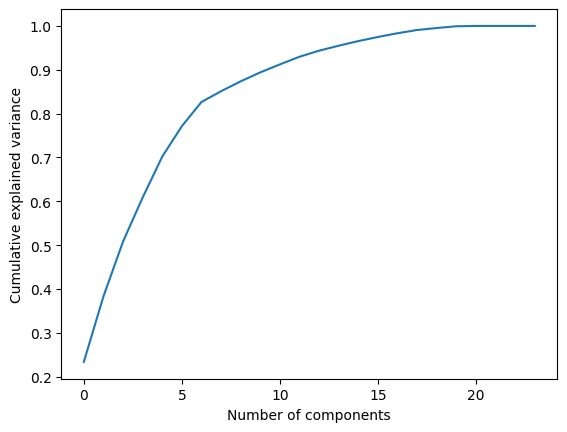

In [5]:
# proportion of variance explained en fonction du nombre de composantes
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


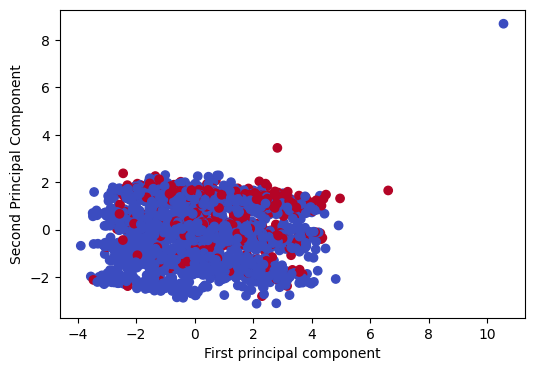

In [6]:
# pca 
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# plot pca
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()




---
## ***Modèles***
---

                     accuracy
Logistic Regression  0.811828
Random Forest        0.802419
SVC                  0.805108
KNN                  0.775538
Decision Tree        0.680108
XGBoost              0.797043
Naive Bayes          0.731183
Dummy                0.798387


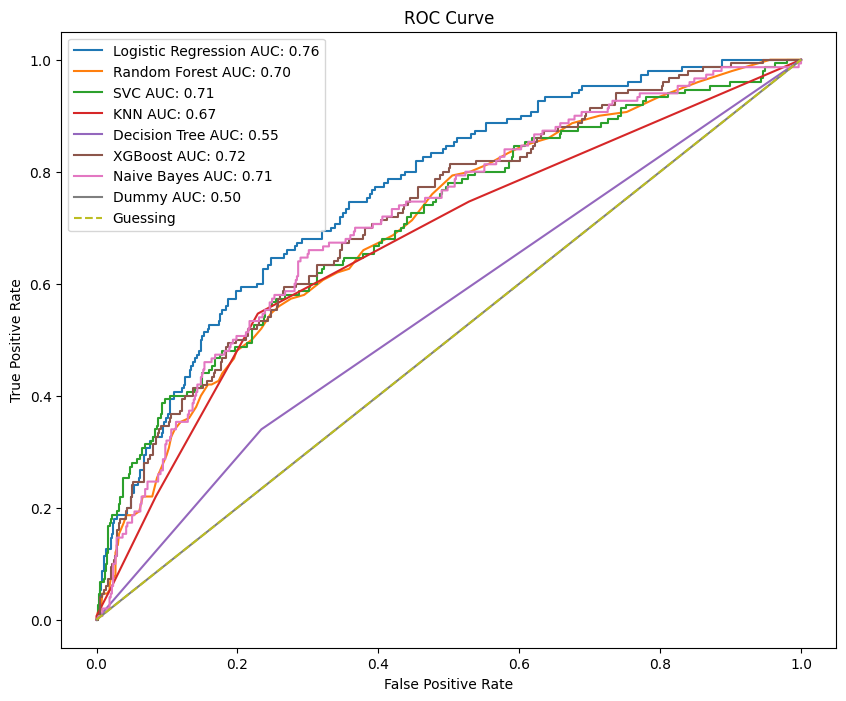

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
# dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Dummy": DummyClassifier( strategy='most_frequent', random_state=42)   # COMPARAISON IMPORTANTE
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)

# plot un tableau avec les scores
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
print(model_compare.T)


# roc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc



# plot roc curve

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} AUC: {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], "--", label="Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

plot_roc_curve(models, X_test, y_test)






### ***Evaluate Classifier***

In [18]:
from sklearn.model_selection import cross_val_score

def evaluate_classifier(clf):
    name = getattr(clf, 'name', clf.__class__.__name__)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    
    # Effectuer une validation croisée
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    display(HTML(
        f"<h2>{name}</h2>"
        f"Test Accuracy: <b>{score:7.2%}</b> <br/>"
        f"<br/>"
        f"<span style='color:green;'><b>Balanced accuracy: {balanced_score:7.2%}</b></span> <br/>" 
        f"<br/>"
        f"Cross-validation score: <b>{mean_cv_score:7.2%}</b> <br/>"
        f"<br/>"
        f"AUC: <b>{roc_auc_score(y_test, y_pred):7.2%}</b> <br/>"
        f"<br/>"
        f"R2: <b>{clf.score(X_test, y_test):7.2%}</b> <br/>"
    ))
    
def pca_evaluate_classifier(clf):
    name = getattr(clf, 'name', clf.__class__.__name__)
    clf.fit(X_train_pca, y_train)
    score = clf.score(X_test_pca, y_test)
    y_pred = clf.predict(X_test_pca)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    display(HTML(
        f"<h2>{name}</h2>"
        f"Test Accuracy: <b>{score:7.2%}</b> <br/>"
        f"Balanced accuracy: <b>{balanced_score:7.2%}</b> <br/>"
    ))


---
## ***Tests différentes méthodes de preprocessing et modèles***
---

In [13]:
# pipeline SMOTE + neural network
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

# Créer un pipeline avec SMOTE et un classifieur 
model_mlp = make_pipeline(MLPClassifier(random_state=42, max_iter=1000))
model_mlp.name = "MLP Classifier"
evaluate_classifier(model_mlp)

In [1]:
#mlp

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42, max_iter=1000)
evaluate_classifier(mlp)



KeyboardInterrupt: 

In [ ]:
# dummy classifier
model_dum = DummyClassifier(strategy='most_frequent', random_state=42)
evaluate_classifier(model_dum)